In [83]:
import numpy as np
import pickle
from itertools import combinations
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from utils.util import *
from dataset import get_loaders

In [84]:
ctx_order = 'last'
ctx_order_str = 'ctxL'
analyze_name = 'analyze_regression'

In [85]:
with open('../../results/%s_results_mlp.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)

with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results = pickle.load(f)

with open('../../results/%s_%s_results_rnncell.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnncell_results = pickle.load(f)

with open('../../results/%s_results_stepwisemlp.P' %(analyze_name), 'rb') as f:
    swmlp_results = pickle.load(f)


In [86]:
mlp_runs     = dict_to_list(mlp_results, analyze_name)
rnn_runs     = dict_to_list(rnn_results, analyze_name)
rnncell_runs = dict_to_list(rnncell_results, analyze_name)
swmlp_runs   = dict_to_list(swmlp_results, analyze_name)
mlp_runs.keys()

dict_keys(['cat_reg', 'con_reg'])

In [87]:
reg_analyze_name = 'cat_reg'
mlp_cat_runs     = dict_to_list(mlp_runs, reg_analyze_name)
rnn_cat_runs     = dict_to_list(rnn_runs, reg_analyze_name)
rnncell_cat_runs = dict_to_list(rnncell_runs, reg_analyze_name)
swmlp_cat_runs   = dict_to_list(swmlp_runs, reg_analyze_name)
mlp_cat_runs.keys()

dict_keys(['p_val', 't_val', 'param', 'y_hat_E', 'y', 'bse'])

In [88]:
data = get_loaders(batch_size=32, meta=False,
                    use_images=True, image_dir='../images/',
                    n_episodes=None, N_responses=None, N_contexts=None,
                    cortical_task='face_task')
train_data, train_loader, test_data, test_loader, analyze_data, analyze_loader = data

In [89]:
y_hat_Es = mlp_cat_runs['y_hat_E'] # [runs, checkpoints, n_combinations]: [20, 21, 120]
ys = mlp_cat_runs['y'] 
np.asarray(y_hat_Es).shape

(20, 21, 120)

In [90]:
def calc_rsa_dis(results, test_data):
    y_hat_Es = np.asarray(results['y_hat_E']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
    ys = np.asarray(results['y'])
    cp = -1
    n_states = test_data.n_states 
    loc2idx = test_data.loc2idx 
    idxs = [idx for idx in range(n_states)]
    locs = [loc for loc, idx in loc2idx.items()]
    wE = ys - y_hat_Es
    wE = wE.mean(axis=0)[cp]
    print(wE.shape)
    rsa_dist = np.zeros(shape=(n_states, n_states))
    for i, (idx1, idx2) in enumerate(combinations(idxs, 2)):
        rsa_dist[idx1][idx2] = wE[i]
        rsa_dist[idx2][idx1] = wE[i]
    return rsa_dist


In [91]:
rsa_dist_mlp     = calc_rsa_dis(mlp_cat_runs, test_data)
# rsa_dist_swmlp   = calc_rsa_dis(swmlp_cat_runs, test_data)
rsa_dist_rnn     = calc_rsa_dis(rnn_cat_runs, test_data)
rsa_dist_rnncell = calc_rsa_dis(rnncell_cat_runs, test_data)


(120,)
(120,)
(120,)


In [92]:
y_hat_Es = np.asarray(swmlp_cat_runs['y_hat_E']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
ys = np.asarray(swmlp_cat_runs['y'])
y_hat_Es.shape


(20, 21, 120, 2)

In [93]:
y_hat_Es = np.asarray(swmlp_cat_runs['y_hat_E']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
ys = np.asarray(swmlp_cat_runs['y'])

runs, checkpoints, n_combinations, n_hidds = y_hat_Es.shape
ys_swmlp = np.zeros([runs, checkpoints, n_combinations, n_hidds])
yhats_swmlp = np.zeros([runs, checkpoints, n_combinations, n_hidds])
for r in range(runs):
    for cp in range(checkpoints):
        yhats_swmlp[r,cp,:,:] = y_hat_Es[r,cp]
        ys_swmlp[r,cp,:,:] = ys[r,cp]
cp = -1
n_states = test_data.n_states 
loc2idx = test_data.loc2idx 
idxs = [idx for idx in range(n_states)]
locs = [loc for loc, idx in loc2idx.items()]
wE = ys_swmlp - yhats_swmlp
wE = wE.mean(axis=0)[cp]
rsa_dist_swmlp = np.zeros(shape=(n_states, n_states, n_hidds))
for i, (idx1, idx2) in enumerate(combinations(idxs, 2)):
    for h in range(n_hidds):
        rsa_dist_swmlp[idx1,idx2,h] = wE[i,h]
        rsa_dist_swmlp[idx2,idx1,h] = wE[i,h]
print(rsa_dist_swmlp.shape)

(16, 16, 2)


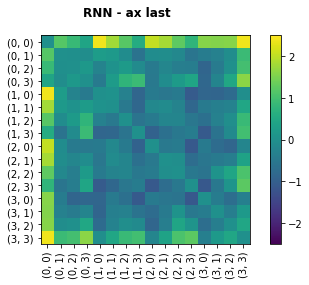

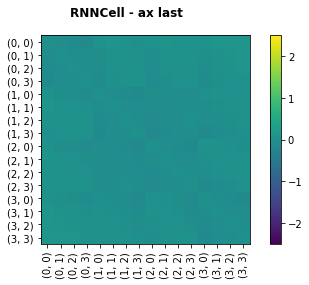

In [94]:
vmin, vmax = -2.5, 2.5

fig, axs = plt.subplots()
plt.imshow(rsa_dist_rnn, vmin=vmin, vmax=vmax)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = '%s_rsa_rnn' %(ctx_order_str)
fig.suptitle('RNN - ax %s' %(ctx_order), fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)

fig, axs = plt.subplots()
plt.imshow(rsa_dist_rnncell, vmin=vmin, vmax=vmax)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = '%s_rsa_rnncell' %(ctx_order_str)
fig.suptitle('RNNCell - ax %s' %(ctx_order), fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)

fig, axs = plt.subplots()
plt.imshow(rsa_dist_mlp, vmin=vmin, vmax=vmax)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = 'rsa_mlp'
fig.suptitle('MLP', fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)

fig, axs = plt.subplots()
plt.imshow(rsa_dist_swmlp[:,:,0], vmin=vmin, vmax=vmax)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = 'rsa_swmlp_hidd1'
fig.suptitle('Stepwise MLP - Hidden 1', fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)


fig, axs = plt.subplots()
plt.imshow(rsa_dist_swmlp[:,:,1], vmin=vmin, vmax=vmax)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = 'rsa_swmlp_hidd2'
fig.suptitle('Stepwise MLP - Hidden 2', fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)


- put all the above figures together?
- I tried it, the issue was:
    - colorbars
    - removing white spaces between plots 
    - it didn't look good a the end

In [ ]:
# fig, axs = plt.subplots(2,2,figsize=[15,5])
# ax = axs[0][0]
# ax.imshow(rsa_dist_rnn)
# ax.set_title('RNN - ax %s' %(ctx_order), fontweight='bold')
# # ax.set_xticks(idxs, locs, rotation='90')
# # ax.set_yticks(idxs, locs)

# ax = axs[0][1]
# ax.imshow(rsa_dist_mlp)
# ax.set_title('MLP', fontweight='bold')

# ax = axs[1][0]
# ax.imshow(rsa_dist_swmlp[:,:,0])
# ax.set_title('Stepwise MLP - Hidden 1', fontweight='bold')

# ax = axs[1][1]
# ax.imshow(rsa_dist_swmlp[:,:,1])
# ax.set_title('Stepwise MLP - Hidden 2', fontweight='bold')

# for ax in axs.flatten():
#     ax.set_xticks(idxs)
#     ax.set_xticklabels(locs, rotation='90')
#     ax.set_yticks(idxs)
#     ax.set_yticklabels(locs)

# # plt.gca().xaxis.set_major_locator(plt.NullLocator())
# # plt.gca().yaxis.set_major_locator(plt.NullLocator())
# # fig.colorbar(rsa_dist_mlp, cax=axs[2])
# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig_str = '%s_rsa_three_models' %(ctx_order_str)
# plt.tight_layout()   
# plt.show()
# fig.savefig(('../../figures/' + fig_str + '.jpg'),
#             bbox_inches = 'tight', pad_inches=0)
